# Create a Financial Analyst Agent

This tutorial combines the components developed in the `1_document_retrieval`, `2_google_search` and `3_controller` notebooks, along with several new components that will be introduced in this notebook, into a Financial Analyst Agent.

This agent will be able to answer user questions from leveraging 3 unique sources of information:
1) the Microsoft 2022 10-K financial statements
2) Google Search and News
3) Historical stock trading data 

Each of these sources of information will be accessible through running a specific Chain. Our custom controller will be responsible for selecting which data sources to use / which chains to execute and then to aggregate the results into a single response.

The Microsoft financial statements chain will be based on the work in `1_document_retrieval`. The Google Search and News chain will be based on the work in `2_google_search`. The historical stock trading data chain will be based on a new skill using PandasAI, a Python library designed to make pandas dataframes conversational by allowing you to ask questions to your data in natural language. 

We will also build a custom evaluator that passes along information to the controller to help it aggregate the results from executed chains.

This tutorial highlights the ability to create an Agent that can synthesize a response from multiple different sources, leveraging different technologies such as document similarity search and automatic code generation, and unifying every component using the `council` framework.

## Import the required modules

In [44]:
from typing import List, Tuple
import logging
import os
import json
from string import Template

import pandas as pd
import tiktoken
from transformers import AutoTokenizer
from tiktoken import Encoding

from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext, StorageContext
from llama_index.langchain_helpers.text_splitter import TokenTextSplitter
from llama_index.node_parser import SimpleNodeParser
from llama_index.indices.vector_store import VectorIndexRetriever
from llama_index.schema import NodeWithScore

from pandasai import PandasAI
from pandasai.llm.openai import OpenAI

from council.skills import SkillBase, LLMSkill, PromptToMessages
from council.runners import Budget
from council.contexts import SkillContext, ChatMessage
from council.llm import OpenAILLM, LLMMessage
from council.chains import Chain
from council.controllers import LLMController, ExecutionUnit
from council.agents import Agent
from council.contexts import AgentContext, ChatHistory, ScoredChatMessage, ChatMessage, ChatMessageKind
from council.prompt import PromptBuilder
from council.skills.google import GoogleSearchSkill, GoogleNewsSkill
from council.runners import Parallel
from council.evaluators import EvaluatorBase

logger = logging.getLogger(__name__)

import dotenv
dotenv.load_dotenv()

True

## Specifying constants used in the notebook

In [70]:
COMPANY_NAME = "Microsoft"
COMPANY_TICKER = "MSFT"

DOC_AND_GOOGLE_RETRIEVAL_LLM = 'gpt-3.5-turbo'
PANDAS_LLM = 'gpt-3.5-turbo'
CONTROLLER_LLM = 'gpt-4'

PDF_FILE_NAME = "msft-10K-2022.pdf"
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
ENCODING_NAME = "cl100k_base"
MAX_CHUNK_SIZE = 256
CHUNK_OVERLAP = 20
CONTEXT_TOKEN_LIMIT = 3000
NUM_RETRIEVED_DOCUMENTS = 50

## Controller

The custom controller performs the two-step process of understanding and classifying a user's query in a conversational context when selecting a plan, and aggregates the responses from all successfully executed chains into a final response.

See notebook `3_controller` for implementation details.

In [131]:
class Controller(LLMController):
    """
    A controller that uses an LLM to decide the execution plan and
    reformulates the user query based on the conversational history.

    Based on LLMController: https://github.com/chain-ml/council/blob/main/council/controllers/llm_controller.py
    """

    def __init__(self, llm, response_threshold):
        """
        Initialize a new instance

        Parameters:
            llm (LLMBase): the instance of LLM to use
            response_threshold (float): a minimum threshold to select a response from its score
        """
        super().__init__(llm, response_threshold)

    def get_plan(self, context: AgentContext, chains: List[Chain], budget: Budget) -> List[ExecutionUnit]:
        """Generates an execution plan for the agent based on the provided context, chains, and budget."""
        self.chains = chains
        answer_choices = "\n ".join([f"name: {c.name}, description: {c.description}" for c in chains])
        # Load prompts for LLM and substitute parameters
        system_prompt = "You are an assistant responsible to identify the intent of the user."
        
        controller_get_plan_prompt = Template("""
        Use the latest user query and the conversational history to identify the intent of the user. 
        Break this task down into 2 subtasks. First perform subtask 1 and then subtask 2.
        
        Context for subtask 1:
        Conversational history:
        $conversational_history
        
        User query: $user_query
        
        Instructions for subtask 1:
        # Use the historical conversation to update the user query to better answer the user question
        # If the query does not need to be updated, do not update the query
        # If there is no conversational history, do not update the query
        # If the conversational history is not relevant to the query, do not update the query
        # See the below examples for how to update the user query
        ************
        Example 1:
        Conversational History:
        User: Who is the CEO of OpenAI?
        Assistant: Sam Altman
        
        User Query: How old is he?
        
        Updated Query: How old is Sam Altman?
        ************
        Example 2:
        Conversational History:
        User: Who is the CEO of OpenAI?
        Assistant: Sam Altman
        
        User Query: What is the price of Bitcoin?
        
        Updated Query: What is the price of Bitcoin?
        ************
        
        Context for subtask 2: 
        Categories are given as a name and a category (name: {name}, description: {description}):
        $answer_choices
        
        Instructions for subtask 2:
        # Use the updated query to identify the intent of the user
        # score categories out of 10 using there description
        # For each category, you will answer with {name};{score}"
        # The updated query should be identical for each category
        # Each response is provided on a new line
        # When no category is relevant, you will answer exactly with 'unknown'
                                        
        Your response should always be formatted like this:
        Subtask 1: {updated_query}
        ---
        Subtask 2:
        {subtask2_results}
        """)
        
        user_prompt = controller_get_plan_prompt.substitute(
            conversational_history=self.build_chat_history(context),
            user_query=context.chatHistory.last_user_message.message,
            answer_choices=answer_choices,
        )
        # Send messages and receive response from model
        messages = [
            LLMMessage.system_message(system_prompt),
            LLMMessage.user_message(user_prompt),
        ]
        response = self._llm.post_chat_request(messages)[0]
        logger.debug(f"llm response: {response}")
        # Separate reformulated query and chain selection from response
        query_reformulation_result, chain_selection_result = self.parse_response(response)
        # Create execution plan and provide reformulated query to each execution unit as its initial state
        parsed = [self.parse_line(line, chains) for line in chain_selection_result.splitlines()]
        filtered = [r.unwrap() for r in parsed if r.is_some() and r.unwrap()[1] > self._response_threshold]
        if (filtered is None) or (len(filtered) == 0):
            return []

        filtered.sort(key=lambda item: item[1], reverse=True)
        # List of chain names to be executed by agent in current iteration
        self.chains_current_iteration = [chain.name for chain, _ in filtered]
        result = [
            ExecutionUnit(r[0], budget, initial_state=ChatMessage.chain(query_reformulation_result))
            for r in filtered
            if r is not None
        ]

        return result[: self._top_k]

    def select_responses(self, context: AgentContext) -> List[ScoredChatMessage]:
        """Selects responses from the agent's context."""
        agent_messages = context.evaluationHistory[-1]
        query = context.chatHistory.last_user_message.message
        chain_descriptions = {chain.name: chain.description for chain in self.chains}
        context = ""
        for message in agent_messages:
            # Only aggregate results from chains executed in current iteration
            if message.message.source in self.chains_current_iteration:
                context += f"Source: {chain_descriptions[message.message.source]}\n Response: {message.message.message}\n\n"

        system_prompt = "You are a financial analyst whose job is to write a research report answering the user query based on data about Microsoft from different sources."

        controller_select_response_prompt = Template("""
        # Instructions
        - The provided context is a list of research data answering the user query from different sources.
        - Combine the following data from muliple sources into a single research report to answer the query.
        - Make sure to highlight any agreements or disagreements between different responses in the final response.
        - Explicitly state from which source different parts of the final response are from.
        
        # Context:
        $context
        
        # Query:
        $query
        
        Answer:
        """)
        prompt = controller_select_response_prompt.substitute(
            context=context, query=query
        )

        messages = [
            LLMMessage.system_message(system_prompt),
            LLMMessage.user_message(prompt),
        ]

        llm_response = self._llm.post_chat_request(messages=messages)[0]

        return [ScoredChatMessage(ChatMessage.agent(llm_response), 1.0)]

    @staticmethod
    def parse_response(response: str) -> Tuple[str, str]:
        """Function to separate reformulated query and chain selection from LLM response."""
        query_reformulation_response = (
            response.split("---")[0].replace("Subtask 1:", "").replace("Subtask 1: ", "").strip()
        )
        chain_selection_response = response.split("---")[1].replace("Subtask 2:", "").replace("Subtask 2: ", "").strip()

        return query_reformulation_response, chain_selection_response

    @staticmethod
    def build_chat_history(context: AgentContext, max_history_len: int = 4) -> str:
        """Format the chat history into a string that can be added to the prompt for the query reformulation model."""
        chat_history = ""
        # Remove the user's most recent message from the chat history
        message_history = context.chatHistory.messages[:-1]
        # Return no history if there are less than 2 messages
        if len(message_history) < 1:
            return "No conversational history"

        for msg in message_history[-max_history_len:]:
            if msg.is_of_kind(ChatMessageKind.User):
                chat_history += f"User: {msg.message}\n"
            if msg.is_of_kind(ChatMessageKind.Agent):
                chat_history += f"Assistant: {msg.message}\n"

        return chat_history


## Document Retrieval

The below components will be used in the document retrieval chain used by the Financial Analyst Agent. They are based on the `1_document_retrieval` notebook.

The key change we make here is in the `DocRetrievalSkill`, where the query is no longer the one sent by the user, but it is the reformulated query created by the custom controller. The Agent adds the initial state (which is where the controller stored the reformulated query) of the chain's ExecutionUnit to the chain's chat history when it begins its execution. Therefore, we can use `context.current.messages[-1].message` to select the most recent message in the chain context's chat history, which is the reformulated query added. 

In [ ]:
class ChunkingTokenizer:
    """Tokenizer for chunking document data for creation of embeddings"""

    def __init__(self, model_name: str):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def __call__(self, text: str) -> List[int]:
        return self.tokenizer.encode(text)

# Instantiate tokenizer for chunking
chunking_tokenizer = ChunkingTokenizer(EMBEDDING_MODEL_NAME)

# Instantiate tokenizer for OpenAI LLM
text_splitter = TokenTextSplitter(
    chunk_size=MAX_CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    tokenizer=chunking_tokenizer,
    separator="\n\n",
    backup_separators=["\n", " "])

# Instantiate text splitter
llm_tokenizer = tiktoken.get_encoding(ENCODING_NAME)

# Instantiate node parser
node_parser = SimpleNodeParser(text_splitter=text_splitter)

# Specify the embedding model and node parser
service_context = ServiceContext.from_defaults(
    embed_model=f"local:{EMBEDDING_MODEL_NAME}", node_parser=node_parser)

# Extract the text from the pdf document
documents = SimpleDirectoryReader(input_files=["msft-10K-2022.pdf"]).load_data()

# Create the index by splitting text into nodes and calculating text embeddings
index = VectorStoreIndex.from_documents(documents, service_context=service_context)

# Initialize index as retriever for top K most similar nodes
index_retriever = index.as_retriever(similarity_top_k=NUM_RETRIEVED_DOCUMENTS)

# Define utility class for document retrieval with LlamaIndex
class Retriever:
    def __init__(self, llm_tokenizer: Encoding, retriever: VectorIndexRetriever):
        """Class to retrieve text chunks from Llama Index and create context for LLM"""
        self.llm_tokenizer = llm_tokenizer
        self.retriever = retriever

    def retrieve_docs(self, query) -> str:
        """End-to-end functiont to retrieve most similar nodes and build the context"""
        nodes = self.retriever.retrieve(query)
        docs = self._extract_text(nodes)
        context = self._build_context(docs)

        return context

    @staticmethod
    def _extract_text(nodes: List[NodeWithScore]) -> List[str]:
        """Function to extract the text from the retrieved nodes"""
        return [node.node.text for node in nodes]

    def _build_context(self, docs: List[str]) -> str:
        """Function to build context for LLM by separating text chunks into paragraphs"""
        context = ""
        num_tokens = 0
        for doc in docs:
            doc += "\n\n"
            num_tokens += len(self.llm_tokenizer.encode(doc))
            if num_tokens <= CONTEXT_TOKEN_LIMIT:
                context += doc
            else:
                break

        return context


class DocRetrievalSkill(SkillBase):
    """Skill to retrieve documents and build context"""

    def __init__(self, retriever: Retriever):
        super().__init__(name="document_retrieval")
        self.retriever = retriever

    def execute(self, context: SkillContext, budget: Budget) -> ChatMessage:
        query = context.current.messages[-1].message
        context = self.retriever.retrieve_docs(query)

        return self.build_success_message(context)

## Google Search

The below components will be used in the Google search chain used by the Financial Analyst Agent. They are based on the `2_google_search` notebook, with several key differences.


The skill for Google Search is not council's GoogleSearchSkill, but rather we make a new skill `CustomGoogleSearchSkill` that skips execution if the required API keys are not set and, similar to the change in the `DocRetrievalSkill`, the query used for the search is the reformulated query created by the controller.

Similarily, the `CustomGoogleNewsSkill` is created to use the controller's reformulated query for the search.

In [50]:
class CustomGoogleSearchSkill(GoogleSearchSkill):
    """
    A skill that performs a Google search using the reformulated query from the controller.

    Based on GoogleSearchSkill: https://github.com/chain-ml/council/blob/main/council/skills/google/google_search_skill.py
    """

    def execute(self, context: SkillContext, budget: Budget) -> ChatMessage:
        # Execute the skill only if the API keys required for Google Search are provided
        if self.gs:
            prompt = context.current.messages[-1]
            resp = self.gs.execute(query=prompt.message, nb_results=5)
            response_count = len(resp)
            if response_count > 0:
                return self.build_success_message(
                    f"{self._name} {response_count} responses for {prompt.message}", json.dumps([r.dict() for r in resp])
                )
            return self.build_error_message("no response")
        return self.build_error_message("API keys for Google Search not provided")


class CustomGoogleNewsSkill(GoogleNewsSkill):
    """
    A skill that performs a Google News search using the reformulated query from the controller.
    
    Based on GoogleNewsSkill: https://github.com/chain-ml/council/blob/main/council/skills/google/google_news_skill.py
    """

    def execute(self, context: SkillContext, budget: Budget) -> ChatMessage:
        prompt = context.current.messages[-1]
        resp = self.gn.execute(query=prompt.message, nb_results=5)
        response_count = len(resp)
        if response_count > 0:
            return self.build_success_message(
                f"gnews {response_count} responses for {prompt.message}", json.dumps([r.dict() for r in resp])
            )
        return self.build_error_message("no response")

class GoogleAggregator(SkillBase):
    """Skill to aggregate results from Google Search and Google News"""

    def __init__(
        self,
    ):
        super().__init__(name="google_aggregator")

    def execute(self, context: SkillContext, budget: Budget) -> ChatMessage:
        gsearch_results = (
            json.loads(context.current.last_message_from_skill("gsearch").data)
            if context.current.last_message_from_skill("gsearch").is_ok
            else []
        )
        gnews_results = (
            json.loads(context.current.last_message_from_skill("gnews").data)
            if context.current.last_message_from_skill("gnews").is_ok
            else []
        )
        search_results = gsearch_results + gnews_results

        context = ""
        for result in search_results:
            text = result.get("title", "") + " " + result.get("snippet", "") + "\n\n"
            context += text

        return self.build_success_message(context)

## PandasAI Skill

The `PandasSkill` is a wrapper around [PandasAI](https://github.com/gventuri/pandas-ai/tree/main), a Python library that integrates generative AI capabilities into Pandas, making dataframes conversational.

It loads a csv file containing stock price and volume data for Microsoft into a dataframe, uses an LLM to generate Python code to answer the user query, and then returns a natural language response to the user.

In [71]:
class PandasSkill(SkillBase):
    """
    Skill to converse with pandas Dataframe using PandasAI.
    
    PandasAI: https://github.com/gventuri/pandas-ai/tree/main
    """

    def __init__(self, api_token, model):
        super().__init__(name="pandas")
        self.llm = OpenAI(api_token=api_token, model=model)

    def execute(self, context: SkillContext, budget: Budget) -> ChatMessage:
        query = context.current.messages[-1].message

        df = pd.read_csv("MSFT.csv")
        pandas_ai = PandasAI(self.llm, conversational=True)

        try:
            response = pandas_ai(data_frame=df, prompt=query)
            if "Unfortunately, I was not able to answer your question, because of the following error:" in response:
                return self.build_error_message(response)
            return self.build_success_message(response)
        except Exception as e:
            return self.build_error_message(f"PandasAI failed due to following error: {e}")

## Evaluator

Our custom evaluator is a simple extension of the `BasicEvaluator` that adds the name of the chain as a source to the `ScoredChatMessage`. The chain name is passed along to the controller so that it can map the chain name to the chain description. The controller uses the chain description as an explanation of the source for each chain's response that is used in the LLM prompt in its `get_responses` method. 

In [52]:
class Evaluator(EvaluatorBase):
    """
    A BasicEvaluator that filters for chains that executed successfully and carries along the chain name in the source of the returned ScoredChatMessage.
    """
    def execute(self, context: AgentContext, budget: Budget) -> List[ScoredChatMessage]:
        result = []
        for chain_name, chain_history in context.chainHistory.items():
            chain_result = chain_history[-1].messages[-1]
            if chain_result.is_kind_skill and chain_result.is_ok:
                result.append(
                    ScoredChatMessage(
                        ChatMessage.agent(
                            message=chain_result.message, data=None, source=chain_name, is_error=chain_result.is_error
                        ),
                        1.0,
                    )
                )
        return result

# Initialize Agent

## Initialize Skills

In [72]:
# Document retrieval skill
doc_retrieval_skill = DocRetrievalSkill(Retriever(llm_tokenizer, index_retriever))

# LLM Skill
llm_skill_model = OpenAILLM.from_env(model=DOC_AND_GOOGLE_RETRIEVAL_LLM)

SYSTEM_MESSAGE = "You are a financial analyst whose job is to answer user questions about $company with the provided context."

PROMPT = """Use the following pieces of context to answer the query.
If the answer is not provided in the context, do not make up an answer. Instead, respond that you do not know.

CONTEXT:
{{chain_history.last_message}}
END CONTEXT.

QUERY:
{{chat_history.user.last_message}}
END QUERY.

YOUR ANSWER:
"""

def build_context_messages(context: SkillContext) -> List[LLMMessage]:
    """Context messages function for LLMSkill"""
    context_message_prompt = PromptToMessages(prompt_builder=PromptBuilder(PROMPT))
    return context_message_prompt.to_user_message(context)


llm_skill = LLMSkill(
    llm=llm_skill_model,
    system_prompt=Template(SYSTEM_MESSAGE).substitute(company=COMPANY_NAME),
    context_messages=build_context_messages,
)

# Google search skills
google_search_skill = CustomGoogleSearchSkill()
google_news_skill = CustomGoogleNewsSkill()
google_aggregator_skill = GoogleAggregator()

pandas_skill = PandasSkill(api_token=os.getenv("OPENAI_API_KEY"), model=PANDAS_LLM)

## Initialize Chains

The Financial Analyst Agent will have 3 chains; one for document retrieval, one for searching with Google and one for analyzing a dataframe of historical stock price and trading data with LLM-generated code.

In [73]:
doc_retrieval_chain = Chain(
    name="doc_retrieval_chain",
    description=f"Information from {COMPANY_NAME} ({COMPANY_TICKER}) 10-K from their 2022 fiscal year, a document that contain important updates for investors about company performance and operations",
    runners=[doc_retrieval_skill, llm_skill],
)

search_chain = Chain(
    name="search_chain",
    description=f"Information about {COMPANY_NAME} ({COMPANY_TICKER}) using a Google search",
    runners=[
        Parallel(google_search_skill, google_news_skill),
        google_aggregator_skill,
        llm_skill,
    ],
)

pandas_chain = Chain(
    name="pandas_chain",
    description=f"{COMPANY_NAME} ({COMPANY_TICKER}) historical stock price and trading data information",
    runners=[pandas_skill],
)

## Initialize Controller and Evaluator

In [132]:
# Initializing controller LLM
controller_llm = OpenAILLM.from_env(model=CONTROLLER_LLM)
controller = Controller(controller_llm, response_threshold=5)

evaluator = Evaluator()

## Run Agent

In [133]:
agent = Agent(controller, [doc_retrieval_chain, search_chain, pandas_chain], evaluator)

In [134]:
chat_history = ChatHistory()
chat_history.add_user_message("How is the financial performance of Microsoft?")
run_context = AgentContext(chat_history)

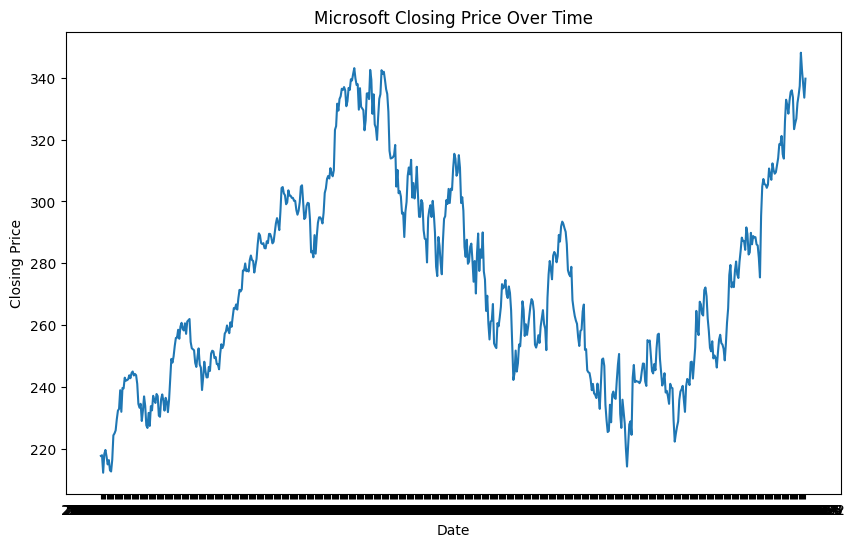

In [135]:
result = agent.execute(run_context, Budget(600))

In [137]:
print(result.best_message.message)

Microsoft's financial performance has been robust, as indicated by data from multiple sources. According to the company's 10-K for the 2022 fiscal year, Microsoft reported significant increases in revenue and operating income across all its segments. The More Personal Computing segment saw a revenue increase of $5.6 billion or 10%, the Productivity and Business Processes segment increased by $9.4 billion or 18%, and the Intelligent Cloud segment increased by $15.2 billion or 25%. The company's operating income also increased by $6.6 billion or 25% overall. However, the gross margin percentage decreased slightly, primarily due to a sales mix shift to Azure and other cloud services.

This strong performance is corroborated by a Google search, which revealed that Microsoft reported record results in fiscal year 2022, with $198 billion in revenue and $83 billion in operating income. The company also reported positive earnings results for the third quarter and nine months ended March 31, 20

In [138]:
run_context.chatHistory.add_agent_message(result.best_message.message)
run_context.chatHistory.add_user_message("What are its business segments?")

In [139]:
result = agent.execute(run_context, Budget(600))

In [141]:
print(result.best_message.message)

Microsoft operates its business in multiple segments. However, there seems to be a discrepancy between the sources regarding the exact number and names of these segments.

According to the information from Microsoft's 10-K from their 2022 fiscal year, the company operates its business and reports its financial performance using three segments: Productivity and Business Processes, Intelligent Cloud, and More Personal Computing.

On the other hand, a Google search suggests that Microsoft operates its business in five segments: Windows & Windows Live Division, Server and Tools, Online Services Division, Microsoft Business Division, and Intelligent Cloud.

It's important to note that the information from the 10-K report is likely to be more accurate and up-to-date as it is a document that contains important updates for investors about company performance and operations. The discrepancy might be due to changes in Microsoft's business structure over time, which are reflected in the most rece